# Ekofisk stereo video WDM test
Use WDM to estimate directional spectrum from Ekofisk stereo video data.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
# Interactive plots
%matplotlib widget 
import cmocean
from pywdm import wdm
from roxsi_pyfuns import wave_spectra

# Read data
datadir = '/home/mikapm/Documents/EKOK'
# Read WAMOS spectrum
# fn_wamos = os.path.join(datadir, 'WAMOS_20200328_1520.nc')
fn_wamos = os.path.join(datadir, 'WAMOS_20200211_1040.nc')
dsw = xr.open_dataset(fn_wamos)
dsw = dsw.rename({'__xarray_dataarray_variable__': 'WAMOS_spec'},)
# Read Ekofisk test stereo data
# fn_nc = os.path.join(datadir, 'xygrid_50cm_20200328_1520_plane_sub.nc')
# fn_nc = os.path.join(datadir, 'xygrid_50cm_20210406_1620_plane_sub.nc')
fn_nc = os.path.join(datadir, 'xygrid_50cm_20200211_1040_plane_sub.nc')
ds = xr.open_dataset(fn_nc, decode_coords='all')
# Change sign of y coord
ds = ds.assign_coords(ym=ds.y * (-1))
ds

<xarray.Dataset>
Dimensions:  (time: 5679, x: 280, y: 300)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-11T10:40:00.383874 ... 2020-02-11T...
  * x        (x) float32 -70.0 -69.5 -69.0 -68.5 -68.0 ... 68.0 68.5 69.0 69.5
  * y        (y) float32 -200.0 -199.5 -199.0 -198.5 ... -52.0 -51.5 -51.0 -50.5
    ym       (y) float32 200.0 199.5 199.0 198.5 198.0 ... 52.0 51.5 51.0 50.5
Data variables:
    xgrid    (x, y) float32 ...
    ygrid    (x, y) float32 ...
    eta      (time, x, y) float32 ...

Pick array of grid cells in stereo field of view and calculate distances and angles.

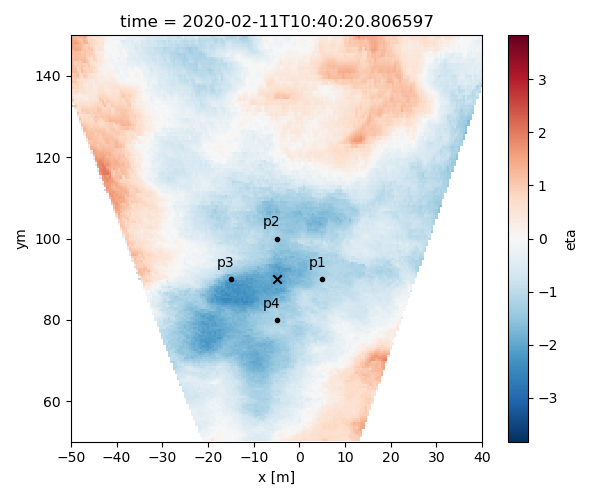

In [2]:
# x,y coordinates of square array
origin = (-5, 90) # x,y coordinates of array origin
sidelen = 10 # array half side length
# xpts = [origin[0]+sidelen, origin[0]-sidelen, 
#         origin[0]-sidelen, origin[0]+sidelen]
# ypts = [origin[1]+sidelen, origin[1]+sidelen, 
#         origin[1]-sidelen, origin[1]-sidelen]
xpts = [origin[0]+sidelen, origin[0], 
        origin[0]-sidelen, origin[0]]
ypts = [origin[1], origin[1]+sidelen, 
        origin[1], origin[1]-sidelen]

# Define A and R arrays for stereo array
# See figure below for visualization of array geometry.
# a_p1 = 45 # Angle from origin to p1 (see figure)
# a_p2 = 135
# a_p3 = 225
# a_p4 = 315
a_p1 = 0 # Angle from origin to p1 (see figure)
a_p2 = 90
a_p3 = 180
a_p4 = 270
# Angles from center
A = np.array([a_p1, a_p2, a_p3, a_p4]).astype(float)
# Convert angles to radians
A *= (np.pi / 180)
# Radius of array (m). i.e. Polar coordinates of the staffs
# o_l1 = np.sqrt(sidelen**2 + sidelen**2) # Distance from origin to p1 (see plot)
# o_l2 = np.sqrt(sidelen**2 + sidelen**2)
# o_l3 = np.sqrt(sidelen**2 + sidelen**2)
# o_l4 = np.sqrt(sidelen**2 + sidelen**2)
o_l1 = sidelen + 0 # Distance from origin to p1 (see plot)
o_l2 = sidelen + 0
o_l3 = sidelen + 0
o_l4 = sidelen + 0
R = np.array([o_l1, o_l2, o_l3, o_l4])
# Make virtual wave staff array (interpolate over NaNs)
arr = np.array([ds.eta.sel(x=xpts[0], y=-ypts[0], method='nearest').interpolate_na(dim='time').bfill(
                    dim='time').ffill(dim='time').values.squeeze(), 
                ds.eta.sel(x=xpts[1], y=-ypts[1], method='nearest').interpolate_na(dim='time').bfill(
                    dim='time').ffill(dim='time').values.squeeze(), 
                ds.eta.sel(x=xpts[2], y=-ypts[2], method='nearest').interpolate_na(dim='time').bfill(
                    dim='time').ffill(dim='time').values.squeeze(),
                ds.eta.sel(x=xpts[3], y=-ypts[3], method='nearest').interpolate_na(dim='time').bfill(
                    dim='time').ffill(dim='time').values.squeeze(),
               ]) 
# Check that array is even
if not (arr.shape[-1] % 2) == 0:
    arr = arr[:, :-1]
    # Time axis for plot
    t = ds.sel(x=xpts[0], y=ypts[0], method='nearest').interpolate_na(dim='time').bfill(
            dim='time').ffill(dim='time').time.values[:-1]
else:
    t = ds.sel(x=xpts[0], y=ypts[0], method='nearest').interpolate_na(dim='time').bfill(
            dim='time').ffill(dim='time').time.values

# Plot array on top of sample grid for visualization
fig, ax = plt.subplots(figsize=(6,5))
ds.isel(time=100).eta.plot(ax=ax, x='x', y='ym')
for i, (xp, yp) in enumerate(zip(xpts, ypts)):
    ax.scatter(xp, yp, color='k', marker='.')
    # Name points p1-p4
    ax.annotate(f'p{i+1:0d}', xy=(xp-3, yp+3), )
# Mark origin w/ x
ax.scatter(origin[0], origin[1], color='k', marker='x')
# Crop limits
ax.set_ylim([50, 150])
ax.set_xlim([-50, 40])
plt.tight_layout()
plt.show()

Estimate WDM spectrum and make example plot.

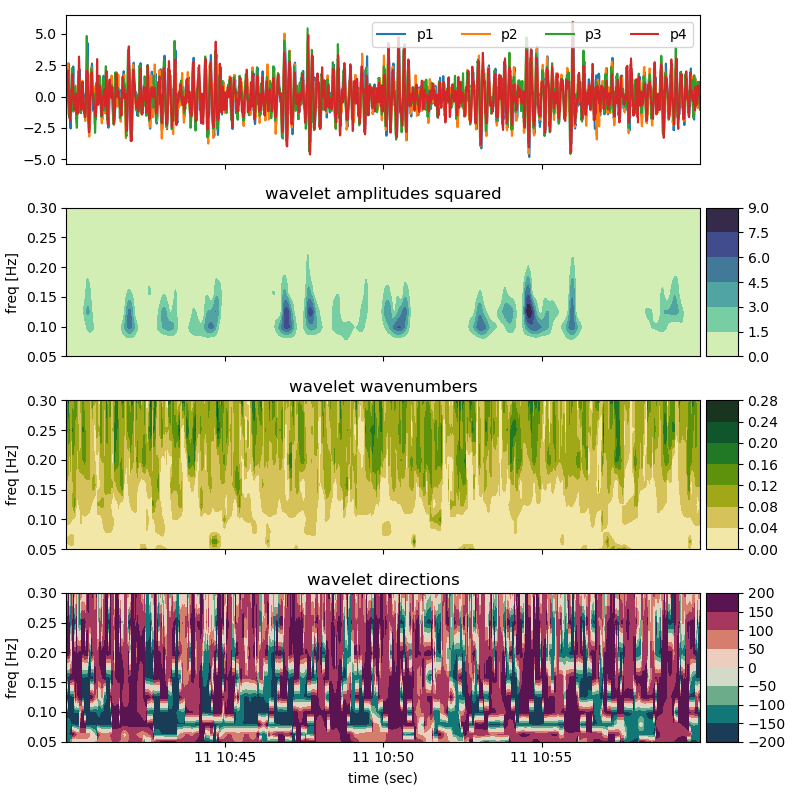

In [3]:
# Initialize WDM class using default parameters
WDM = wdm.WaveletDirectionalMethod(A, R, lf=0.05, hf=0.8, nv=3)
# Run WDM algorithm
Amp, K, Th, freqs = WDM.wdm_kth(arr.T)
# Get f-theta and f spectra
res = 10
dse = WDM.spec_fth(Amp, Th*(180/np.pi), freqs, res=res)

# Plot time series and wavelet amplitudes^2, wavenumbers and directions
fig, axes = plt.subplots(figsize=(8,8), nrows=4, sharex=True)
ims = {} # dict for images for colorbars
# Plot array time series on top
for i in range(4):
    axes[0].plot(t, arr[i], label=f'p{i+1:0d}')
axes[0].set_xlabel(None)
axes[0].set_title(None)
axes[0].legend(loc='upper right', ncol=4)
# Row 2: Wavelet amplitudes ^ 2
ims['1'] = axes[1].contourf(t, freqs, Amp**2, cmap=cmocean.cm.deep)
axes[1].set_title('wavelet amplitudes squared')
axes[1].set_ylabel('freq [Hz]')
# Row 3: Wavelet wavenumbers
ims['2'] = axes[2].contourf(t, freqs, K, cmap=cmocean.cm.speed)
axes[2].set_ylabel('freq [Hz]')
axes[2].set_title('wavelet wavenumbers')
# Row 4: Wavelet directions
ims['3'] = axes[3].contourf(t, freqs, np.rad2deg(Th), cmap=cmocean.cm.curl)
axes[3].set_ylabel('freq [Hz]')
axes[3].set_xlabel('time (sec)')
axes[3].set_title('wavelet directions')
# Colorbars
for i,ax in enumerate(axes[1:]):
    cax = axes[i+1].inset_axes([1.01, 0.00, 0.05, 1.0], transform=axes[i+1].transAxes)
    fig.colorbar(ims[f'{i+1:0d}'], cax=cax, orientation='vertical')
# x-lims
for ax in axes[1:]:
    ax.set_ylim([0.05, 0.3])
plt.tight_layout()
plt.show()
# plt.close()

Plot frequency-directional spectra.

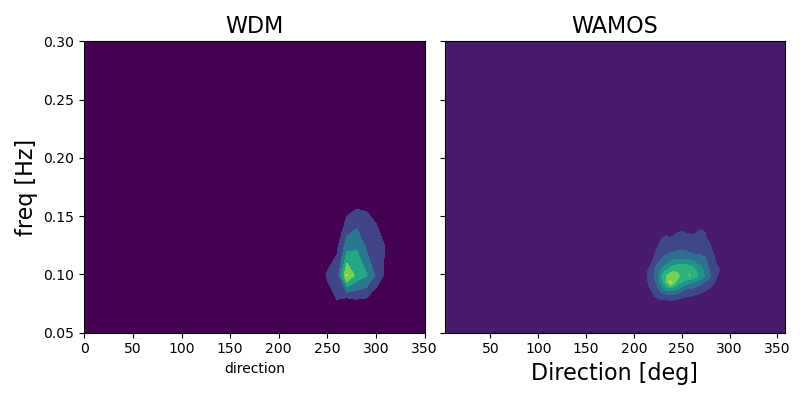

In [4]:
fig, axes = plt.subplots(figsize=(8,4), ncols=2, sharey=True)
# WDM spec
# axes[0].contourf(dirs, freqs, Efd,)# locator=ticker.LogLocator(), cmap=cm.PuBu_r)
dse.Efth.plot.contourf(ax=axes[0], add_colorbar=False)
axes[0].set_title('WDM', fontsize=16)
axes[0].set_ylabel('freq [Hz]', fontsize=16)
# WAMOS spec
axes[1].contourf(dsw.direction.data, dsw.freq, dsw.WAMOS_spec.T,)# locator=ticker.LogLocator(), cmap=cm.PuBu_r)
# axes[1].set_xlim([100, 200])
axes[1].set_ylim([0.05, 0.3])
axes[1].set_title('WAMOS', fontsize=16)
axes[1].set_xlabel('Direction [deg]', fontsize=16)
plt.tight_layout()
plt.show()

Plot frequency spectra (sanity check).

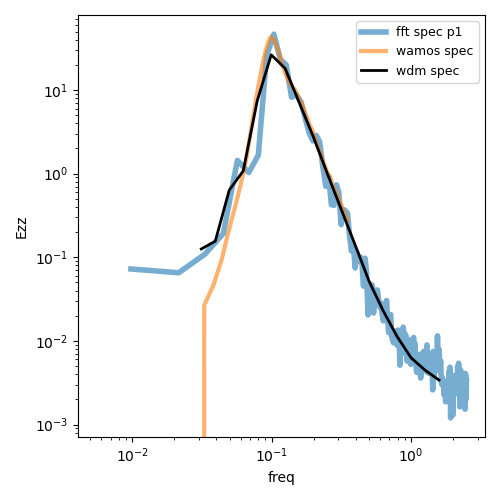

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
# Regular FFT spectra
for i in range(1):
    dss = wave_spectra.spec_uvz(arr[i], fs=5)
    dss.Ezz.plot(ax=ax, label='fft spec p{}'.format(i+1), lw=4, alpha=0.6)
# WAMOS frequency spectrum
dth = np.deg2rad(dsw.direction[1] - dsw.direction[0]) # dir. res.
ax.loglog(dsw.freq, dsw.WAMOS_spec.sum(axis=0)*dth, label='wamos spec', lw=3, alpha=0.6)
# WDM spectrum
ax.loglog(dse.freq, dse.Efth.integrate(coord='direction'), label='wdm spec', color='k', lw=2)

ax.legend(fontsize=9)
plt.tight_layout()
plt.show()



In [6]:
# Print spectral dataset
dse

<xarray.Dataset>
Dimensions:    (freq: 18, direction: 36)
Coordinates:
  * freq       (freq) float64 0.03125 0.03937 0.04961 0.0625 ... 1.0 1.26 1.587
  * direction  (direction) int64 0 10 20 30 40 50 60 ... 300 310 320 330 340 350
Data variables:
    Efth       (freq, direction) float64 0.0001053 0.0001168 ... 8.77e-06
    Hm0        float64 5.325
    fp         float64 0.09921
    mdir       float64 282.3
    dspr       float64 27.39